In [13]:
from polygon import RESTClient
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
# get data
stock_symbol = "NVDA"  # Replace with your desired stock symbol
day = "2024-03-25"
client = RESTClient("sOdQWQgI2Zs3yEUZSlBJObKba52LLMPg")  # Replace with your Polygon API key
aggs = client.get_aggs(stock_symbol, 1, "minute", day, day)

# prepare data
timestamps = []
close_prices = []
for agg in aggs:
    timestamps.append(datetime.fromtimestamp(agg.timestamp // 1000))
    close_prices.append(agg.close)

close_prices = np.array(close_prices)

x_close = []
y_close = []
for i in range(0, len(aggs), 1):
  agg = aggs[i]
  x_close.append(datetime.fromtimestamp(agg.timestamp // 1000).time().strftime("%H:%M"))
  y_close.append(agg.close)


In [42]:
def calculate_ema(data, period):
    return data.ewm(span=period, adjust=False).mean()

def calculate_macd(data):
    ema_12 = calculate_ema(data, 12)
    ema_26 = calculate_ema(data, 26)
    macd_line = ema_12 - ema_26
    signal_line = calculate_ema(macd_line, 9)
    return macd_line, signal_line


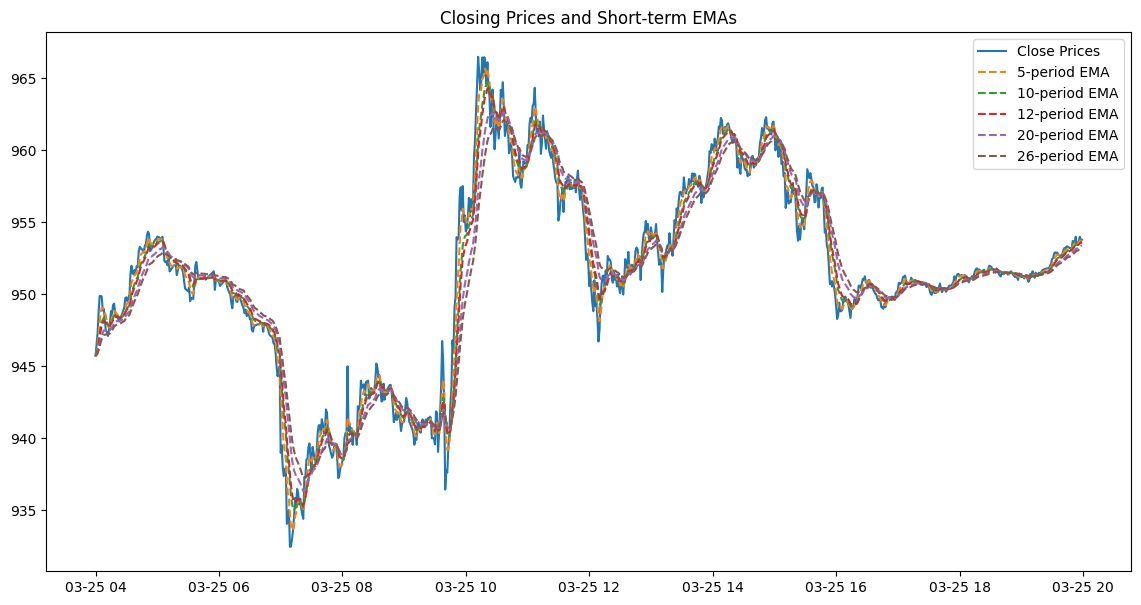

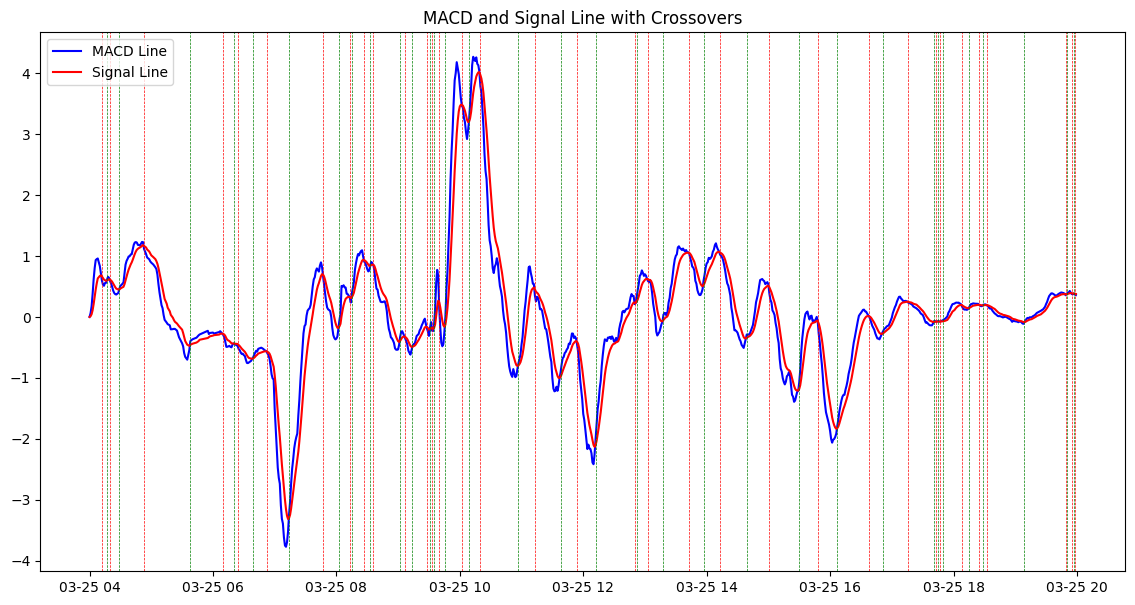

In [43]:
# Convert close prices to Pandas Series
close_series = pd.Series(close_prices)

# Calculate MACD and Signal line
macd_line, signal_line = calculate_macd(close_series)

# Calculate short-term EMAs
ema_5 = calculate_ema(close_series, 5)
ema_10 = calculate_ema(close_series, 10)
ema_12 = calculate_ema(close_series, 12)
ema_20 = calculate_ema(close_series, 20)
ema_26 = calculate_ema(close_series, 26)

# Plot closing prices
plt.figure(figsize=(14, 7))
plt.plot(timestamps, close_prices, label='Close Prices')
plt.plot(timestamps, ema_5, label='5-period EMA', linestyle='--')
plt.plot(timestamps, ema_10, label='10-period EMA', linestyle='--')
plt.plot(timestamps, ema_12, label='12-period EMA', linestyle='--')
plt.plot(timestamps, ema_20, label='20-period EMA', linestyle='--')
plt.plot(timestamps, ema_26, label='26-period EMA', linestyle='--')
plt.title('Closing Prices and Short-term EMAs')
plt.legend()
plt.show()

# Plot MACD and Signal line with crossovers
plt.figure(figsize=(14, 7))
plt.plot(timestamps, macd_line, label='MACD Line', color='blue')
plt.plot(timestamps, signal_line, label='Signal Line', color='red')

buys = []
sells = []

# highlight crossovers
for i in range(1, len(macd_line)):
    if (macd_line[i-1] < signal_line[i-1]) and (macd_line[i] > signal_line[i]):
        plt.axvline(x=timestamps[i], color='green', linestyle='--', linewidth=0.5)  # Bullish crossover
        buys.append(x_close[i])
    elif (macd_line[i-1] > signal_line[i-1]) and (macd_line[i] < signal_line[i]):
        plt.axvline(x=timestamps[i], color='red', linestyle='--', linewidth=0.5)  # Bearish crossover
        sells.append(x_close[i])
plt.title('MACD and Signal Line with Crossovers')
plt.legend()
plt.show()

In [44]:

#Aggregate Transactions

transaction_times = sorted(buys + sells)
transactions = []
for t in transaction_times:
    price = y_close[x_close.index(t)]
    if t in buys:
        transactions.append([t, price, "Buy"])
    else:
        transactions.append([t, price, "Sell"])


#Execute Transactions through simulation
print("Running Simulation for MACD with", stock_symbol, "on", day)

print("Number of Transactions: ", len(transactions))
#print(transactions)
print("Open Price, Close Price: ", y_close[0], y_close[-1])
cash = 100000
shares = 1000
print("Cash and Shares: ", cash, shares)
portfolio_val_s = cash + y_close[0]*shares
print("BOD portfolio: ", portfolio_val_s)
amt = cash * 0.2

for order in transactions:
    if order[2] == "Buy":
        cash -= amt
        shares += amt/order[1]
    else:
        cash += amt
        shares -= amt/order[1]

print("Cash and Shares: ", cash, shares)
portfolio_val_e = cash + y_close[-1]*shares
print("EOD portfolio: ", portfolio_val_e)
print("Profit: ", portfolio_val_e - portfolio_val_s, (portfolio_val_e - portfolio_val_s)/portfolio_val_s * 100, "%")
    


Running Simulation for MACD with NVDA on 2024-03-25
Number of Transactions:  67
Open Price, Close Price:  945.73 953.79
Cash and Shares:  100000 1000
BOD portfolio:  1045730.0
Cash and Shares:  120000.0 979.1665394807137
EOD portfolio:  1053919.25369131
Profit:  8189.253691310063 0.7831135848938122 %
